In [4]:
import pandas as pd
import numpy as np
import pickle
import time 
import os
from datetime import datetime
from operator import itemgetter
import time

# 需要什么读取什么不要一次性全都读取了，影响程序速度

data_folder_path = '../'
raw_data_path = "../raw_data"
storage_path = "../database_storage"
daily_path = "../daily"
DTBS_path = os.path.join(storage_path, "DTBS.pkl")
DCBS_path = os.path.join(storage_path, "DCBS.pkl")

time1 = time.time()

with open('database_ByZCG\\DCBS_DataFrame.pkl', 'rb') as f:  
    DCBS_DataFrame = pickle.load(f)
    

with open('database_ByZCG\\DTBS_DataFrame.pkl', 'rb') as f:  
    DTBS_DataFrame = pickle.load(f)

    
# 只提取A区中存活的转债的时间序列信息
A_DF = DTBS_DataFrame['A']
A_DF = A_DF[A_DF['ia']==1].copy()

# 提取B区信息
B_DF = DTBS_DataFrame['B']

# 提取C区信息
C_DF = DTBS_DataFrame['C']

# 提取D区信息
D_DF = DTBS_DataFrame['D']

In [5]:
# DataFrame新增列用于存放前一天收盘价、涨跌幅
A_DF.sort_values(by = ['bond_code','date'], inplace=True, ascending=[True,True])
A_DF['lastday_dp'] = A_DF.groupby('bond_code')['dp'].shift(1)
A_DF['change'] = A_DF['dp'] / A_DF['lastday_dp'] - 1
A_DF = pd.merge(A_DF, B_DF[['bond_code', 'sn']].drop_duplicates(), on='bond_code', how='left')

# 设定选择区间为n天，得到网格的最高点与最低点
A_DF.sort_values(['bond_code', 'date'], ascending=[True,True], inplace=True)
grouped = A_DF.groupby('bond_code')
n = 126

# 两种不同的计算方式，一种是计算前20天收盘价的最高价、最低价（不含当天），一种是计算前20天收盘价的最高价、最低价（含当天）
# A_DF['highest_price_n_days'] = grouped['dp'].rolling(window=n+1, min_periods=n+1).apply(lambda x: x[:-1].max(), raw=True).reset_index(level=0, drop=True)
# A_DF['lowest_price_n_days'] = grouped['dp'].rolling(window=n+1, min_periods=n+1).apply(lambda x: x[:-1].min(), raw=True).reset_index(level=0, drop=True)

A_DF['highest_price_n_days'] = grouped['dp'].rolling(window=n, min_periods=n).max().reset_index(level=0, drop=True)
A_DF['lowest_price_n_days'] = grouped['dp'].rolling(window=n, min_periods=n).min().reset_index(level=0, drop=True)

In [6]:
print(A_DF[(A_DF['date']=='2022-01-04') & (A_DF['lowest_price_n_days']>=0)])

from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# 解决中文乱码问题
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 指定默认字体：解决plot不能显示中文问题
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

def get_current_total_money(current_date, current_money, current_position_details, A_DF):
    
    """
    这个函数用于获取当前时刻账户内现金+转债价值之和,返回账户总市值
    current_date：现在的日期，
    current_money：代表账户内的现金数目,
    current_position_details：传入持仓明细字典（Key是转债代码，Value是持有这只转债的数量，请传入合法转债代码与数量）
    A_DF：全量数据库中的A区，存放3点收盘价
    """
    
    if current_position_details == {}:
        current_total_money = current_money
    else:
        # 获取当日转债价格字典
        current_day_A_DF = A_DF.loc[A_DF['date'] == current_date,['bond_code','dp']].copy()
        current_day_price_Dict = current_day_A_DF.set_index('bond_code')['dp'].to_dict()        
        current_total_money = current_money   
        
        for hold_bond_code,hold_num in current_position_details.items():            
            # price = float(A_DF.loc[(A_DF['bond_code'] == hold_bond_code) & (A_DF['date'] == current_date),'dp'])
            price = current_day_price_Dict[hold_bond_code]
            bond_money = price * hold_num
            current_total_money = current_total_money + bond_money    
            
    return current_total_money

def display(profit, trade_dates_list, C_DF, photo_title, tick_spacing = 10):
    
    # x轴
    x = trade_dates_list[1:]
    
    # 图片名
    photo_title = trade_dates_list[0] + ' 至 ' + trade_dates_list[-1] + '  ' + photo_title
    
    # 获取中证转债指数列表
    zi_df = C_DF[C_DF['date'].isin(trade_dates_list)][['date','zi']].copy()
    zi_df.sort_values('date', ascending=True, inplace=True)
    zi = list(zi_df['zi'])    
    zi_cumulative_return = [zi[index]/zi[0] - 1 for index in range(1, len(zi))]
    zi_weekly_return = [zi[index]/zi[index-1] - 1 for index in range(1,len(zi))]
    
    # 获取累计收益率
    weekly_return = profit
    cumulative_return = []
    
    cr = 1
    for i in profit:
        cr = cr * (i + 1)
        cumulative_return.append(cr - 1)
        
    print('单周收益率：', weekly_return, '\n', '累积收益率：',cumulative_return, 
          '\n用累加算法算出的策略累计收益率：',sum(weekly_return), '\n用累加算法算出的中证转债累计收益率：', sum(zi_weekly_return))
    
    # 绘制累计净收益率曲线图
    plt.figure(figsize=(30,15),dpi=1200)
    fig, ax = plt.subplots(1, 1)
    plt.plot(x, cumulative_return, color='red', label="策略累计净收益率",linewidth=1)
    plt.plot(x, zi_cumulative_return, color='green', label="中证转债累计净收益率",linewidth=1)
    plt.xlabel("时间")
    plt.ylabel("累计收益率")
    plt.title(photo_title)
    # 图例显示
    plt.legend()
    # 设置打印的密度
    # tick_spacing = 1
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # 设置显示字体的大小
    plt.tick_params(axis='both', labelsize=10)
    # 对x轴进行翻转，竖向显示
    plt.xticks(rotation=90, fontsize=10)
    # 显示图像
    plt.show()
    
    # 绘制单周净收益率曲线图
    plt.figure(figsize=(30,15),dpi=1200)
    fig, ax = plt.subplots(1, 1)
    plt.plot(x, weekly_return, color='red', label="策略单周净收益率",linewidth=1)
    plt.plot(x, zi_weekly_return, color='green', label="中证转债单周净收益率",linewidth=1)
    plt.xlabel("时间")
    plt.ylabel("单周收益率")
    plt.title(photo_title)
    # 图例显示
    plt.legend()
    # 设置打印的密度
    # tick_spacing = 1
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # 设置显示字体的大小
    plt.tick_params(axis='both', labelsize=10)
    # 对x轴进行翻转，竖向显示
    plt.xticks(rotation=90, fontsize=10)
    # 显示图像
    plt.show()

        bond_code        date       cpr       dp         bl        trt  \
5812    110038.SH  2022-01-04   13.2906  150.570   6.303800  86.607443   
9056    110043.SH  2022-01-04   20.1582  122.300  29.213500   1.209200   
10289   110044.SH  2022-01-04  124.8837  206.880   0.708500  21.558200   
11517   110045.SH  2022-01-04   29.0305  118.950  29.496400   0.358800   
12961   110047.SH  2022-01-04   20.6081  122.070  22.461600   1.418900   
...           ...         ...       ...      ...        ...        ...   
387280  128141.SZ  2022-01-04   17.2994  130.300  12.702600   0.620400   
387907  128142.SZ  2022-01-04   41.0310  123.698   7.179800   1.282700   
388526  128143.SZ  2022-01-04   14.9148  129.990   2.443800   4.423800   
389112  128144.SZ  2022-01-04   20.7032  142.010   9.794600   0.678600   
389682  128145.SZ  2022-01-04   14.7608  143.661   3.796918   5.130134   

            ytm        yl        dl  ia  ...  qs15  qs30  xx15  xx30  hs  \
5812   -33.5885  0.860274  163.8606

['2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06', '2023-01-09', '2023-01-10', '2023-01-11', '2023-01-12', '2023-01-13', '2023-01-16', '2023-01-17', '2023-01-18', '2023-01-19', '2023-01-20', '2023-01-30', '2023-01-31', '2023-02-01', '2023-02-02', '2023-02-03', '2023-02-06', '2023-02-07', '2023-02-08', '2023-02-09', '2023-02-10', '2023-02-13', '2023-02-14', '2023-02-15', '2023-02-16', '2023-02-17', '2023-02-20', '2023-02-21', '2023-02-22', '2023-02-23', '2023-02-24', '2023-02-27', '2023-02-28', '2023-03-01', '2023-03-02', '2023-03-03', '2023-03-06', '2023-03-07', '2023-03-08', '2023-03-09', '2023-03-10', '2023-03-13', '2023-03-14', '2023-03-15', '2023-03-16', '2023-03-17', '2023-03-20', '2023-03-21', '2023-03-22', '2023-03-23', '2023-03-24', '2023-03-27', '2023-03-28', '2023-03-29', '2023-03-30', '2023-03-31', '2023-04-03', '2023-04-04', '2023-04-06', '2023-04-07', '2023-04-10', '2023-04-11', '2023-04-12', '2023-04-13', '2023-04-14', '2023-04-17', '2023-04-18', '2023-04-19', '2023

[0.011698610000000054, 0.010794558668020482, 0.017985683726238655, 0.012604389290589824, 0.016394416463163308, -0.01113260314269593, -0.012483393622543137, 0.012930151288940372, 0.024713125675688286, -0.0009638846396311518, -0.0011601260618830933, 0.02584836400605517, 0.007870717927922044, 0.00730967126230575, -0.02321426745567745, 0.014549113253366164, -0.0036048861847982616, 0.013308288258033318, 0.006817516884197294, -0.01020163086880932, 0.00938305825073904, 0.0035609431157348492, -0.0040197417692370285, 0.003726854674149793, -0.011533866981841445, 0.0010523637753458992, -0.008435351093045496, -0.011324254949159784, 0.0070137743294080845, -0.021889689044022775]
单周收益率： [0.011698610000000054, 0.010794558668020482, 0.017985683726238655, 0.012604389290589824, 0.016394416463163308, -0.01113260314269593, -0.012483393622543137, 0.012930151288940372, 0.024713125675688286, -0.0009638846396311518, -0.0011601260618830933, 0.02584836400605517, 0.007870717927922044, 0.00730967126230575, -0.0232

<Figure size 36000x18000 with 0 Axes>

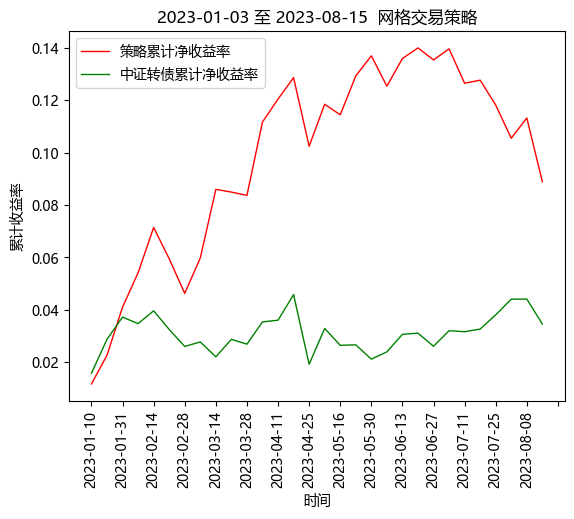

<Figure size 36000x18000 with 0 Axes>

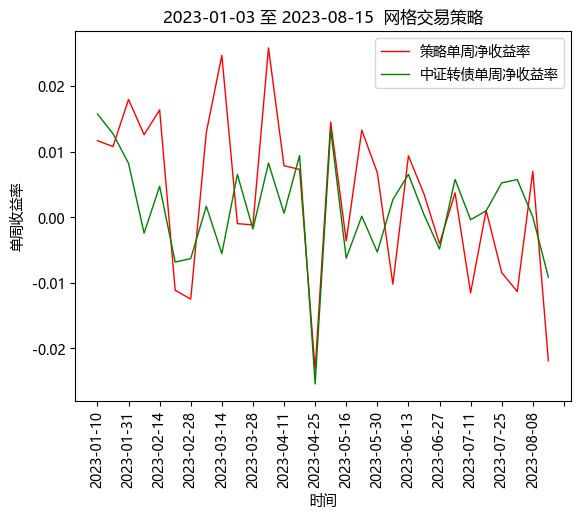

In [28]:
import bisect

start_day = '2023-01-03'
end_day = '2023-08-17'


# 先实验对某一只转债进行网格化交易

# 选债方法剔除掉目前价格过高的转债（存在下跌的风险），按回测开始日期前半年的正股年化波动率由高到低排序
# 113594.SH  113621.SH  127046.SZ  123088.SZ  113629.SH  127052.SZ  123121.SZ
trade_bond_code = '113621.SH'

# 需要交易的转债只数
trade_bond_code_count = 1

day_list = sorted(list(A_DF[(A_DF['date'] >= start_day) & (A_DF['date'] <= end_day) & (A_DF['bond_code'] == trade_bond_code)]['date']))
print(day_list)


# 设置初始资金100万元
initial_money = 1000000

# 每只转债的最大投入资金限额
every_bond_max_money = int(initial_money/trade_bond_code_count)

# 每只转债最大买入份额
max_limit = int(every_bond_max_money / A_DF[(A_DF['date'] == start_day) & (A_DF['bond_code'] == trade_bond_code)]['lowest_price_n_days'] / 10) * 10

# 设计 2k + 1 个格子
n = 11

# 设置网格的最高点/最低点
max_price = float(A_DF[(A_DF['date'] == start_day) & (A_DF['bond_code'] == trade_bond_code)]['highest_price_n_days'])
min_price = float(A_DF[(A_DF['date'] == start_day) & (A_DF['bond_code'] == trade_bond_code)]['lowest_price_n_days'])

print(max_limit, max_price, min_price)

# 设置网格的价格比例
q = (max_price/min_price) ** (1/(n-1))

# 字典中存储每个价位应该持有的债券数量
position_dict = {round(min_price * (q ** i),2) : int(max_limit * (1-i/(n-1)) / 10) * 10 for i in range(n)}

# 网格价目表
price_list = [round(min_price * (q ** i),2) for i in range(n)]

print(q,price_list,position_dict)


total_money_list = []

# dp列表
A_DF.sort_values(by = ['bond_code','date'], inplace=True, ascending=[True,True])
dp_list = list(A_DF[(A_DF['date'].isin(day_list)) & (A_DF['bond_code'] == trade_bond_code)]['dp'])

# print(len(day_list),len(dp_list))

all_date_positon_details = {}
for i in range(len(day_list)):  
    index_1 = bisect.bisect_left(price_list, dp_list[i])
    if index_1 > n-1:
        index_1 = n-1
    print(index_1,dp_list[i])
    all_date_positon_details[day_list[i]] = {trade_bond_code : position_dict[price_list[index_1]]}

print(all_date_positon_details)


# 统计每周账户净值
test_day_list = list(D_DF[(D_DF['date'] >= start_day) & (D_DF['date'] <= end_day) & (D_DF['which_day'] == 'tue')]['date'])

for i in range(len(day_list)):
    day = day_list[i]
    if i == 0:
        # 第一天换仓时
        total_money_list.append(initial_money)
        current_money = initial_money - get_current_total_money(day, 0, all_date_positon_details[day], A_DF)
    else:
        current_total_money = get_current_total_money(day, current_money, all_date_positon_details[day_list[i-1]], A_DF)
        current_money = current_total_money - get_current_total_money(day, 0, all_date_positon_details[day], A_DF)
        if day in test_day_list:
            total_money_list.append(current_total_money)

profit = [total_money_list[i] / total_money_list[i-1] - 1 for i in range(1, len(total_money_list))]
print(profit)

display(profit, test_day_list, C_DF, '网格交易策略', tick_spacing = 2)

In [8]:
print(D_DF)

            date which_day
0     2017-01-03       tue
1     2017-01-04       wed
2     2017-01-05       thu
3     2017-01-06       fri
4     2017-01-09       mon
...          ...       ...
1607  2023-08-14       mon
1608  2023-08-15       tue
1609  2023-08-16       wed
1610  2023-08-17       thu
1611  2023-08-18       fri

[1612 rows x 2 columns]
